# Scenario prototyping

This notebook contains a rough prototype of how a scenario modelling should work. The final approach is available in the `engine/scenario_modelling.ipynb` instead.

## Scenario 3: Densification of inner city

Densification scenario models a high-density development in the areas that are already developed following the strategy of gradual infill and rebuilding of existing buildings into higher ones with more mixed use. It is a long-term strategy aimed at preservation of green areas (especially the green belt) and a creation of 15-minute neighbourhoods in the existing city by adding new layers of functionality and new inhabitants to places that are already built. The scenario affects most of the city with higher densification levels around local centres and main streets and lower in suburban residential areas.

It will be modelled as a change of signature types based on their hierarchy to higher order ones and related estimations of new population and job allocation. Land cover will likely see changes from *‌Discontinuous urban fabric* to *Continuous urban fabric*.

In [1]:
import pickle
import geopandas as gpd
import libpysal
import pandas as pd
import numpy as np

from indicators import Model

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_1435/3890749546.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import contextily 
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import matplotlib.cm
import mapclassify
import husl
import seaborn as sns


from utils import legendgram

In [3]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

Load the data

In [5]:
median_form = pd.read_parquet(f"{data_folder}/sampling/median_form.parquet")
iqr_form = pd.read_parquet(f"{data_folder}/sampling/iqr_form.parquet")
median_function = pd.read_parquet(f"{data_folder}/sampling/median_function.parquet")
iqr_function = pd.read_parquet(f"{data_folder}/sampling/iqr_function.parquet")
oa = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet").set_index('geo_code').rename(columns={"population_estimate":"population"})
oa_key = pd.read_parquet(f"{data_folder}/sampling/oa_key.parquet")

Get OA areas for area-weighted variables.

In [6]:
oa_area = oa.area

Define a sampling method.

In [7]:
def _form(signature_type, variable, random_seed):
    """Get values for form variables
    
    Values are sampled from a normal distribution around
    median of a variable per signature type. The spread is
    defined as 1/5 of interquartile range.
    """    
    rng = np.random.default_rng(random_seed)
    return rng.normal(
        median_form.loc[signature_type, variable], 
        iqr_form.loc[signature_type, variable] / 5, 
    )

def _function(signature_type, variable, random_seed):
    """Get values for function variables
    
    Values are sampled from a normal distribution around
    median of a variable per signature type. The spread is
    defined as 1/5 of interquartile range.
    """
    rng = np.random.default_rng(random_seed)
    return rng.normal(
        median_function.loc[signature_type, variable], 
        iqr_function.loc[signature_type, variable] / 5, 
    )

def _populations(defaults, index):
    """Balance residential and workplace population
    
    Workplace population and residential population are treated 1:1 and
    are re-allocated based on the index. The proportion of workplace categories
    is not changed.
    """
    if not  -1 <= index <= 1:
        raise ValueError(f"use index must be in a range -1...1. {index} given.")
    jobs = [ 
        'A, B, D, E. Agriculture, energy and water',
        'C. Manufacturing', 
        'F. Construction',
        'G, I. Distribution, hotels and restaurants',
        'H, J. Transport and communication',
        'K, L, M, N. Financial, real estate, professional and administrative activities',
        'O,P,Q. Public administration, education and health',
        'R, S, T, U. Other',
    ]
    n_jobs = defaults[jobs].sum()
    if index < 0:
        difference = (index * n_jobs)
    else:
        difference = (index * defaults.population)
    new_n_jobs = n_jobs + difference
    defaults.population = defaults.population - difference
    multiplier = new_n_jobs / n_jobs
    defaults[jobs] = defaults[jobs] * multiplier
    return defaults
    
def _greenspace(defaults, index):
    """Allocate greenspace to OA
    
    Allocate publicly accessible formal greenspace to OA. Defines a portion
    of OA that is covered by gren urban areas. Realistic values are be fairly
    low. The value affects populations and other land cover classes.
    """
    if not  0 <= index <= 1:
        raise ValueError(f"greenspace index must be in a range 0...1. {index} given.")
    greenspace_orig = defaults["Land cover [Green urban areas]"]
    newly_allocated_gs = index - greenspace_orig
    defaults = defaults * (1 - newly_allocated_gs)
    defaults["Land cover [Green urban areas]"] = index
    return defaults

def _job_types(defaults, index):
    """Balance job types
    
    Balance job types between manual and white collar workplace categories.
    Index represents the proportion of white collar jobs in an area. The 
    total sum of FTEs is not changed.
    
    The service category is not affected under an assumption that both white
    and blue collar workers need the same amount of services to provide food etc.
    """
    if not  0 <= index <= 1:
        raise ValueError(f"job_types index must be in a range 0...1. {index} given.")
    blue = [
        "A, B, D, E. Agriculture, energy and water",
        "C. Manufacturing",
        "F. Construction",
        "H, J. Transport and communication"
    ]
    white = [
        "K, L, M, N. Financial, real estate, professional and administrative activities",
        "O,P,Q. Public administration, education and health",
    ]
    blue_collar = defaults[blue].sum()
    white_collar = defaults[white].sum()
    total = blue_collar + white_collar
    orig_proportion = white_collar / total
    
    new_blue = total * (1-index)
    new_white = total * index

    blue_diff = new_blue / blue_collar
    white_diff = new_white / white_collar

    defaults[blue] = defaults[blue] * blue_diff
    defaults[white] = defaults[white] * white_diff
    
    return defaults

def get_signature_values(
    oa_code: str,
    signature_type: str = None, 
    use: float = 0, 
    greenspace: float = None,
    job_types: float = None,
    random_seed: int = None,
):
    """Generate explanatory variables based on a scenario
    
    Generates values for explanatory variables based on empirical data derived
    from the Urban Grammar project and a scenario definition based on a 
    Urban Grammar signature type, land use balance, greenspace allocation
    and a job type balance.
    
    If the target ``signature_type`` differs from the one already allocated 
    to OA, the data is sampled from the distribution from the whole GB. If
    they are equal, the existing values measured in place are used. That allows
    playing with other variables without changing the form.
    
    Parameters
    ----------
    oa_code : string
        String representing the OA code, e.g. ``"E00042707"``.
        
    signature_type : string
        String representing signature type. See below the possible options
        and their relationship to the level of urbanity.
        
            0: 'Wild countryside', 
            1: 'Countryside agriculture', 
            2: 'Urban buffer', 
            3: 'Warehouse/Park land',
            4: 'Open sprawl', 
            5: 'Disconnected suburbia',
            6: 'Accessible suburbia', 
            7: 'Connected residential neighbourhoods',
            8: 'Dense residential neighbourhoods',
            9: 'Gridded residential quarters',
            10: 'Dense urban neighbourhoods', 
            11: 'Local urbanity', 
            12: 'Regional urbanity', 
            13: 'Metropolitan urbanity',
            14: 'Concentrated urbanity', 
            15: 'Hyper concentrated urbanity',
    
    use : float, optional
        Float in a range -1...1 reflecting the land use balance between
        fully residential (-1) and fully commercial (1). Defautls to 0, 
        a value derived from signatures. For values < 0, we are allocating
        workplace population to residential population. For values > 0, we
        are allocating residential population to workplace population.
        Extremes are allowed but are not realistic, in most cases.
    greenspace : float, optional
        Float in a range 0...1 reflecting the amount of greenspace in the 
        area. 0 representes no accessible greenspace, 1 represents whole
        area covered by a greenspace. This value will proportionally affect 
        the amounts of jobs and population.
    job_types : float, optional
        Float in a range 0...1 reflecting the balance of job types in the
        area between entirely blue collar jobs (0) and entirely white collar 
        jobs (1).
    random_seed : int, optional
        Random seed
    
    Returns
    -------
    Series
    """
    orig_type = oa_key.primary_type[oa_code]
    if signature_type is not None and orig_type != signature_type:
        form = pd.Series(
            [_form(signature_type, var, random_seed) for var in median_form.columns],
            index=median_form.columns, 
            name=oa_code
        ).abs()

        
        defaults = pd.Series(
            [_function(signature_type, var, random_seed) for var in median_function.columns],
            index=median_function.columns, 
            name=oa_code
        ).abs()
        
        area_weighted = [
            'population', 
            'A, B, D, E. Agriculture, energy and water',
            'C. Manufacturing', 
            'F. Construction',
            'G, I. Distribution, hotels and restaurants',
            'H, J. Transport and communication',
            'K, L, M, N. Financial, real estate, professional and administrative activities',
            'O,P,Q. Public administration, education and health',
            'R, S, T, U. Other',
        ]
        defaults[area_weighted] = defaults[area_weighted] * oa_area[oa_code]

    
    else:
        form = oa.loc[oa_code][median_form.columns]
        defaults = oa.loc[oa_code][median_function.columns]
    
    # population
    if use != 0:
        defaults = _populations(defaults, index=use)
    
    # greenspace
    if greenspace:
        defaults = _greenspace(defaults, greenspace)
    
    if job_types:
        defaults = _job_types(defaults, job_types)
    return pd.concat([form, defaults])

In [17]:
reg_urb = oa_key[oa_key.primary_type == "Regional urbanity"]
loc_urb = oa_key[oa_key.primary_type == "Local urbanity"]
dense_nei = oa_key[oa_key.primary_type == "Dense urban neighbourhoods"]

In [14]:
data = oa.copy().drop(columns=["air_quality_index", "house_price_index", "jobs_accessibility_index", "greenspace_accessibility_index", "geometry"])

In [40]:
for oa_code in reg_urb.index:
    data.loc[oa_code] = get_signature_values(oa_code, signature_type="Metropolitan urbanity")
for oa_code in loc_urb.index:
    data.loc[oa_code] = get_signature_values(oa_code, signature_type="Regional urbanity")
for oa_code in dense_nei.index:
    data.loc[oa_code] = get_signature_values(oa_code, signature_type="Local urbanity")

In [24]:
data

population  A, B, D, E. Agriculture, energy and water  \
geo_code                                                           
E00042786  315.000000                                   0.547024   
E00042707  525.431526                                   0.690330   
E00042703  246.000000                                   0.110388   
E00042782  277.000000                                   0.478192   
E00042789  271.000000                                   0.680069   
...               ...                                        ...   
E00041811  260.000000                                   6.176392   
E00041818  266.000000                                   6.167524   
E00041898  383.000000                                   0.258177   
E00041819  252.000000                                   1.683364   
E00041388  327.000000                                   0.575491   

           C. Manufacturing  F. Construction  \
geo_code                                       
E00042786          3.146641         5.436732   
E00042707          9.783091        11.011048   
E00042703          1.325208         4.297030   
E00042782          2.732637         4.713528   
E00042789          3.917490         6.768659   
...                     ...              ...   
E00041811         24.554252        16.877050   
E00041818        118.738670        41.325525   
E00041898          9.524011         8.470490   
E00041819          8.425353         6.174154   
E00041388          2.813017         7.114732   

           G, I. Distribution, hotels and restaurants  \
geo_code                                                
E00042786                                    4.839081   
E00042707                                   27.972932   
E00042703                                   11.481138   
E00042782                                    4.167451   
E00042789                                    6.029714   
...                                               ...   
E00041811                                   24.155593   
E00041818                                   29.690504   
E00041898                                   13.848700   
E00041819                                   29.170866   
E00041388                                    6.164085   

           H, J. Transport and communication  \
geo_code                                       
E00042786                           2.065436   
E00042707                          24.213416   
E00042703                           2.315769   
E00042782                           1.776267   
E00042789                           2.573226   
...                                      ...   
E00041811                           7.043768   
E00041818                           9.219951   
E00041898                           5.092474   
E00041819                           5.890583   
E00041388                           2.865501   

           K, L, M, N. Financial, real estate, professional and administrative activities  \
geo_code                                                                                    
E00042786                                           4.283496                                
E00042707                                          28.308583                                
E00042703                                           4.408114                                
E00042782                                           3.689214                                
E00042789                                           5.335117                                
...                                                      ...                                
E00041811                                           9.970712                                
E00041818                                          21.156448                                
E00041898                                           6.438827                                
E00041819                                          10.098662                                
E00041388         

## Air Quality

In [28]:
with open(f"{data_folder}/models/air_quality_predictor.pickle", "rb") as f:
    aqm = pickle.load(f)

In [41]:
aq_predicted = aqm.predict(data.rename(columns={"population": "population_estimate"}))

Plot original Air Quality prediction.

In [34]:
aq_baseline = aqm.predict(oa.drop(columns=["air_quality_index", "house_price_index", "jobs_accessibility_index", "greenspace_accessibility_index", "geometry"]).rename(columns={"population": "population_estimate"}))

In [36]:
from shapely.geometry import box

bds = oa.total_bounds
extent = gpd.GeoSeries([box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=oa.crs).to_crs(3857)

Plot the data.

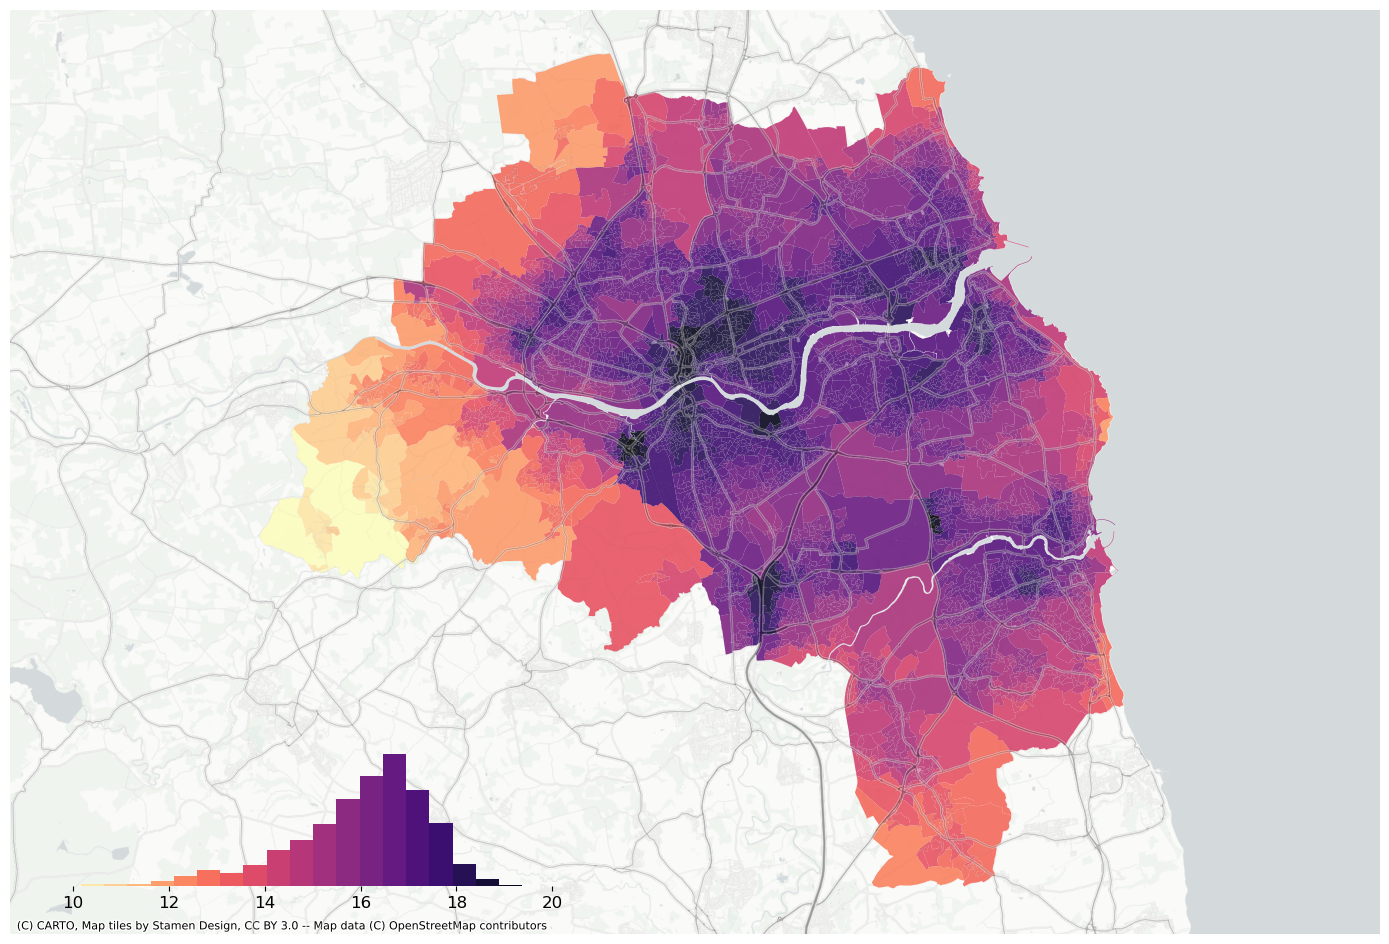

In [63]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(aq_baseline, scheme="equalinterval", k=20, ax=ax, alpha=.9, cmap="magma_r")
bins = mapclassify.EqualInterval(aq_baseline, k=20).bins
legendgram(
    f,
    ax,
    aq_baseline,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/air_quality_baseline.png", dpi=150, bbox_inches="tight")


Plot prediction

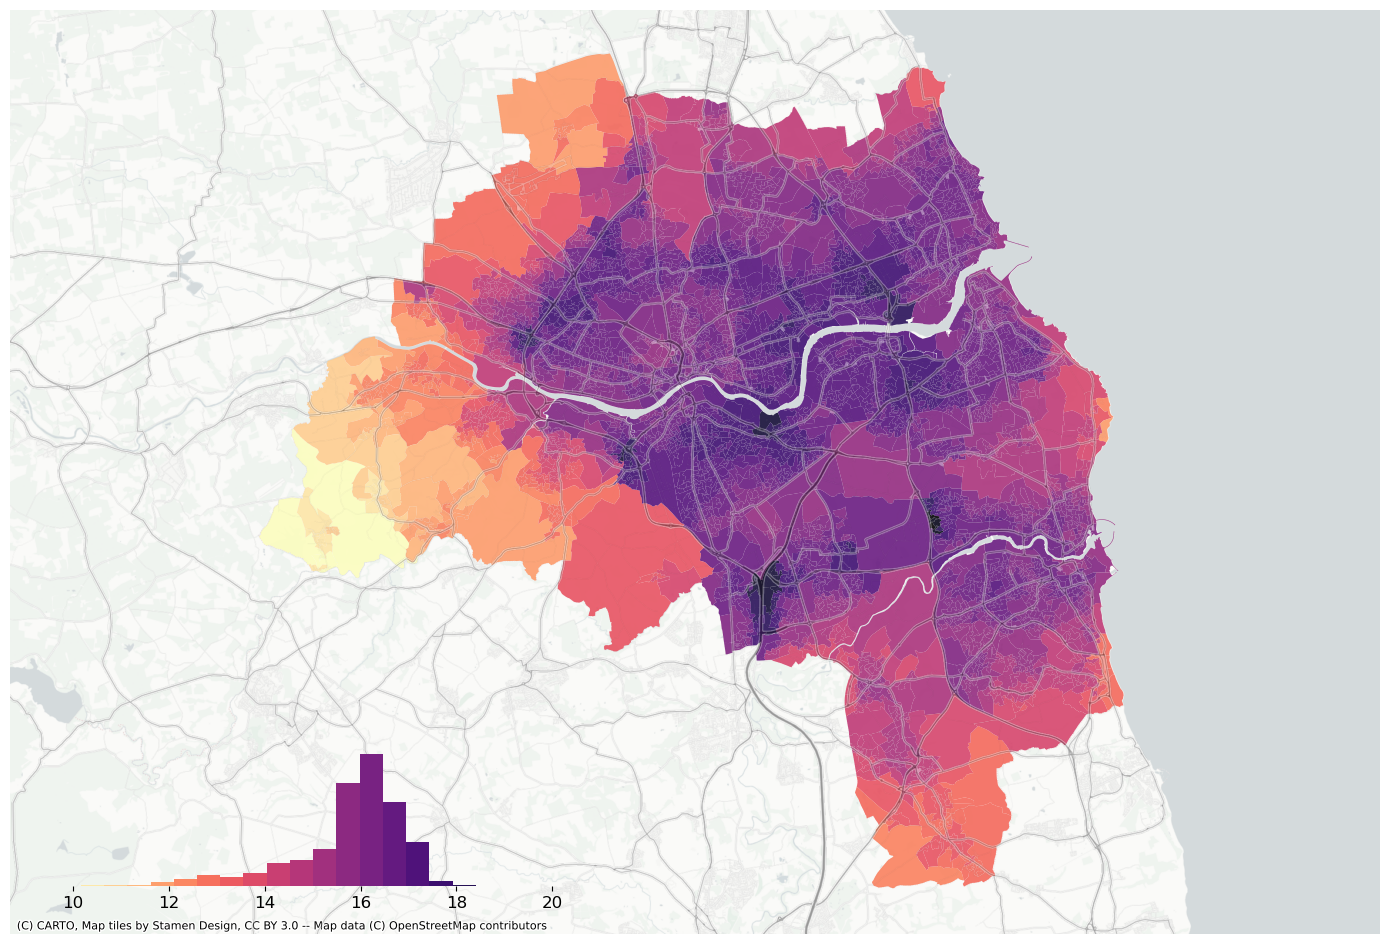

In [64]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(aq_predicted, scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
legendgram(
    f,
    ax,
    aq_predicted,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/sc3_air_quality_index.png", dpi=150, bbox_inches="tight")


<AxesSubplot: ylabel='Frequency'>

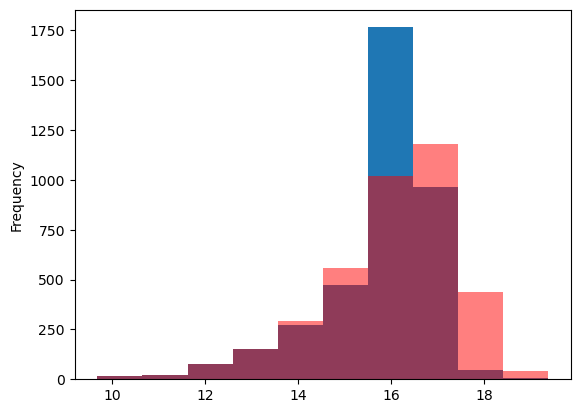

In [65]:
ax = pd.Series(aq_predicted).plot.hist()
pd.Series(aq_baseline).plot.hist(ax=ax, color="r", alpha=.5)

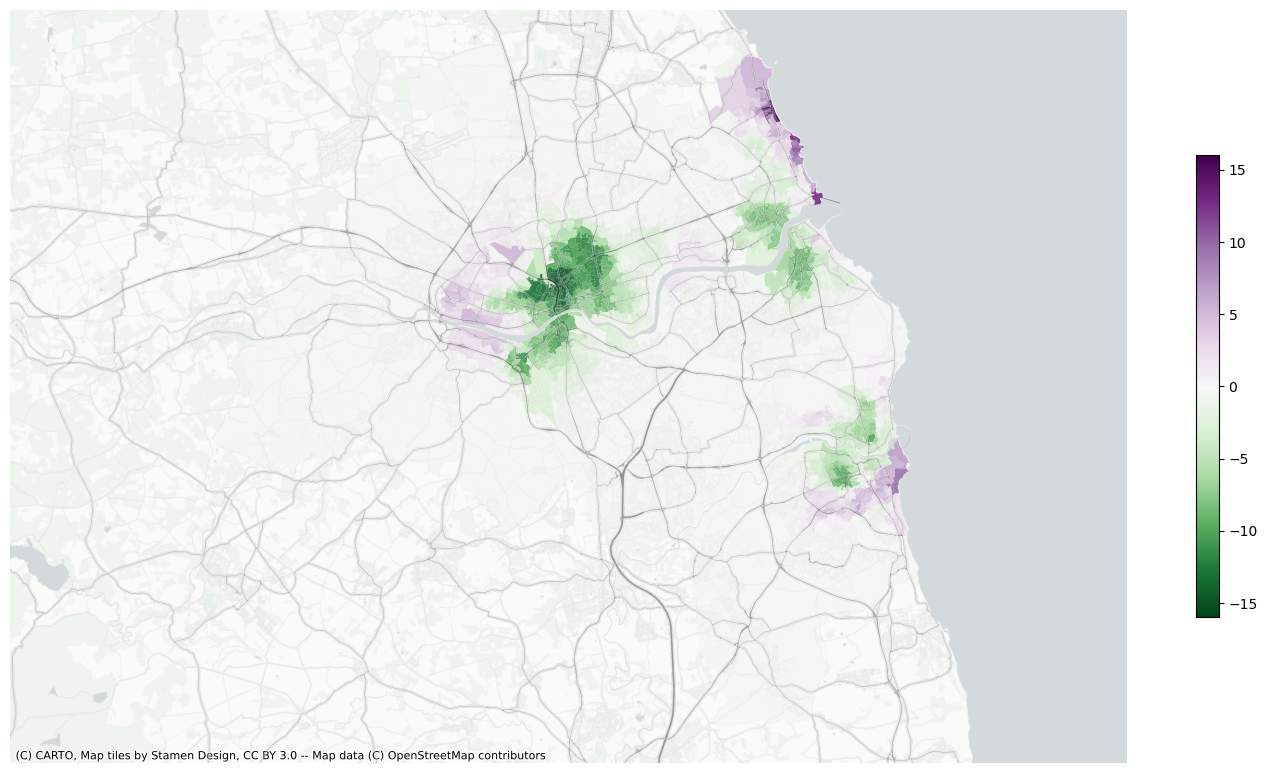

In [66]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(((aq_predicted - aq_baseline) / aq_baseline) * 100, ax=ax, alpha=.9, cmap="PRGn_r", vmin=-16, vmax=16, legend=True, legend_kwds={"shrink": 0.5})
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/sc3_air_quality_diff.png", dpi=150, bbox_inches="tight")

## House Price

In [68]:
with open(f"{data_folder}/models/house_price_predictor.pickle", "rb") as f:
    hpp = pickle.load(f)

In [69]:
hp_predicted = hpp.predict(data.rename(columns={"population": "population_estimate"}))

Plot original Air Quality prediction.

In [70]:
hp_baseline = hpp.predict(oa.drop(columns=["air_quality_index", "house_price_index", "jobs_accessibility_index", "greenspace_accessibility_index", "geometry"]).rename(columns={"population": "population_estimate"}))

Plot the data.

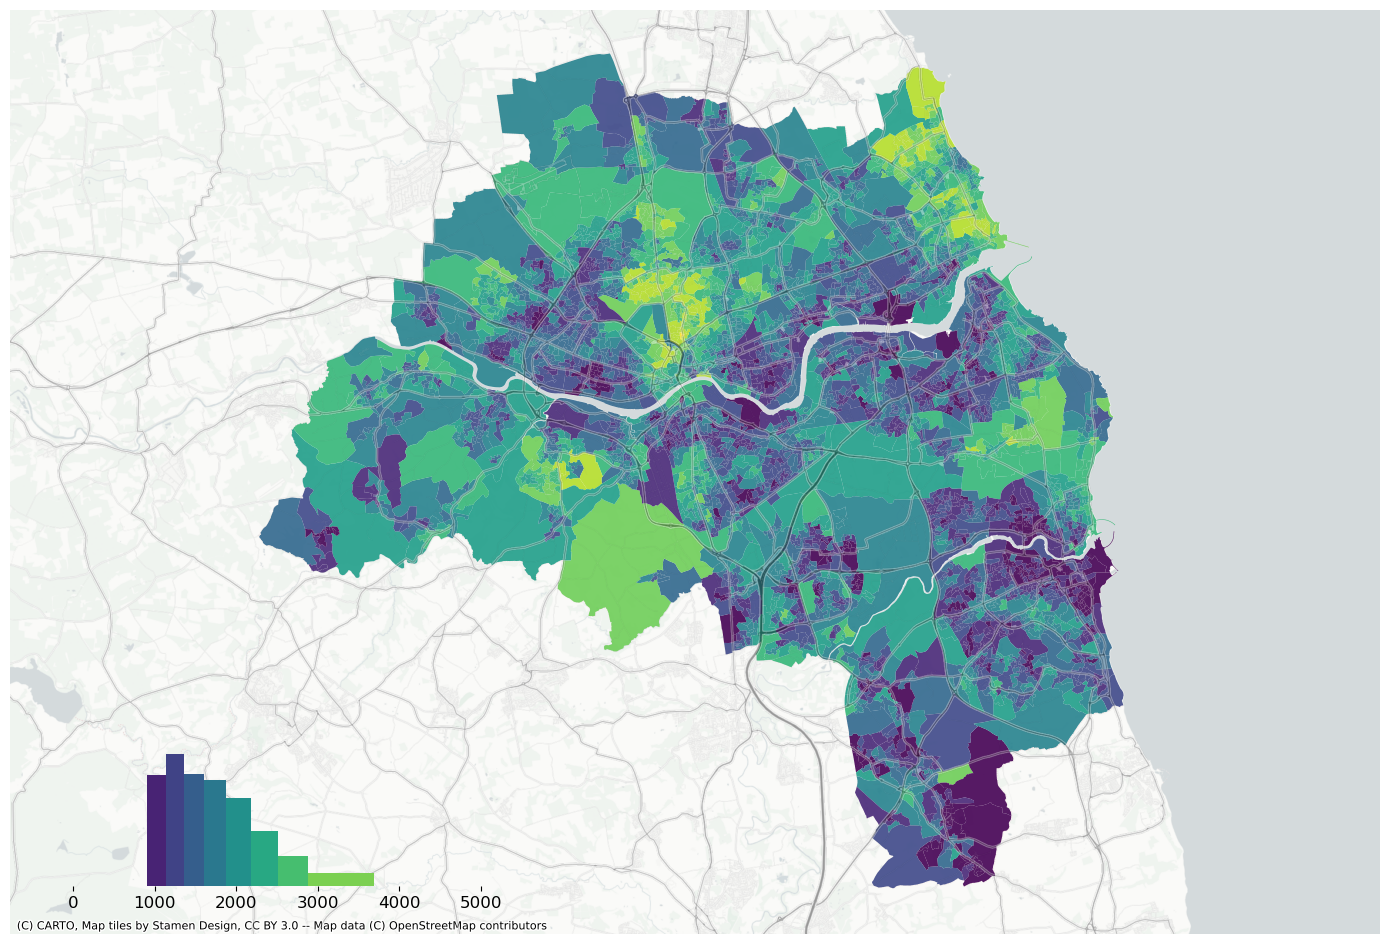

In [71]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(hp_baseline, scheme="naturalbreaks", k=10, ax=ax, alpha=.9, cmap="viridis")
bins = mapclassify.NaturalBreaks(hp_baseline, k=10).bins
legendgram(
    f,
    ax,
    hp_baseline,
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (0, np.max(hp_baseline)), # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/house_price_baseline.png", dpi=150, bbox_inches="tight")


Plot prediction

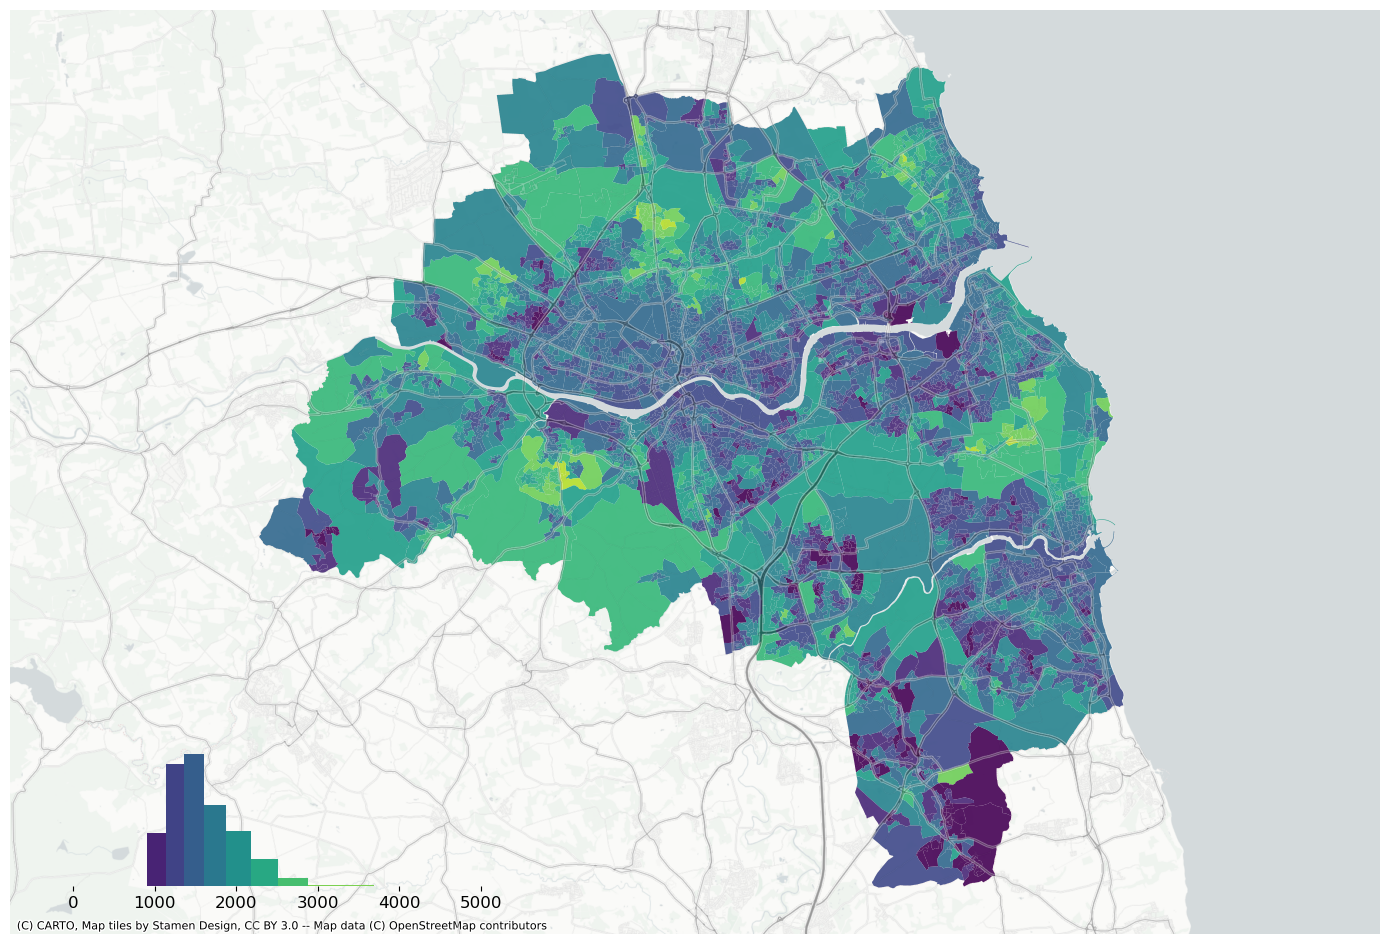

In [72]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(hp_predicted, scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
legendgram(
    f,
    ax,
    hp_predicted,
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (0, np.max(hp_baseline)), # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/sc3_house_price_index.png", dpi=150, bbox_inches="tight")


<AxesSubplot: ylabel='Frequency'>

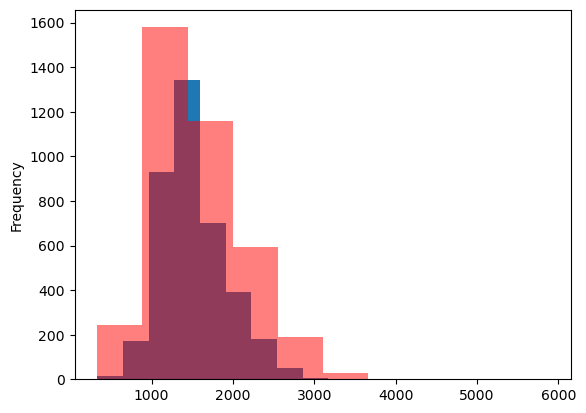

In [73]:
ax = pd.Series(hp_predicted).plot.hist()
pd.Series(hp_baseline).plot.hist(ax=ax, color="r", alpha=.5)

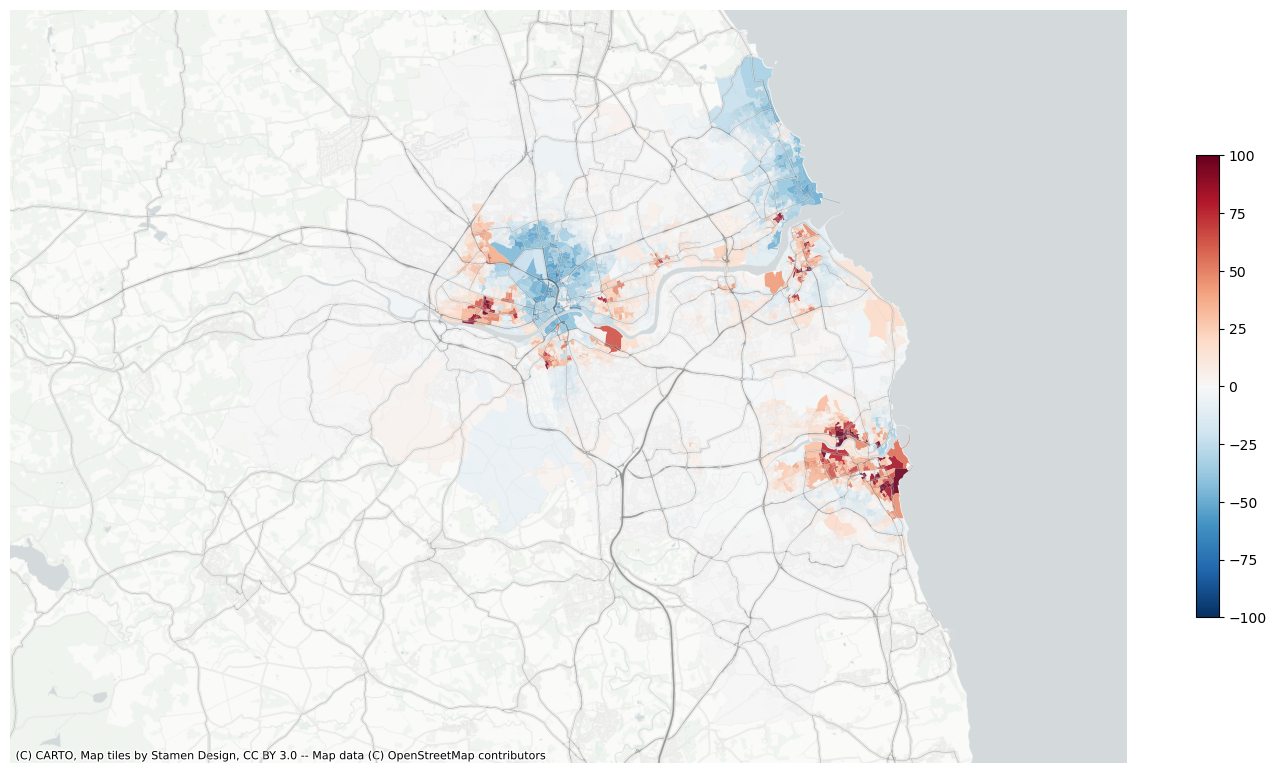

In [81]:
f,ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
oa.to_crs(3857).plot(((hp_predicted - hp_baseline) / hp_baseline) * 100, ax=ax, alpha=.9, cmap="RdBu_r", vmin=-100, vmax=100, legend=True, legend_kwds={"shrink": 0.5})
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.savefig(f"{data_folder}/outputs/scenarios/sc3_house_price_diff.png", dpi=150, bbox_inches="tight")

In [4]:
oa_key = pd.read_parquet(f"{data_folder}/sampling/oa_key.parquet")


In [5]:
oa_key

primary_type
OA11CD                                     
E00041363        Dense urban neighbourhoods
E00041364                    Local urbanity
E00041366  Dense residential neighbourhoods
E00041367  Dense residential neighbourhoods
E00041368  Dense residential neighbourhoods
...                                     ...
E00175601  Dense residential neighbourhoods
E00175602  Dense residential neighbourhoods
E00175603  Dense residential neighbourhoods
E00175604  Dense residential neighbourhoods
E00175605                       Open sprawl

[3795 rows x 1 columns]

In [6]:
import urbangrammar_graphics as ugg

In [12]:
ugg.get_signature_colors()

{'Countryside agriculture': (0.9475259828670731,
  0.9021947232500418,
  0.782113263104546),
 'Accessible suburbia': (0.5625, 0.640625, 0.4921875),
 'Open sprawl': (0.8429158144969133, 0.6476876988954169, 0.6238940322088141),
 'Wild countryside': (0.8429616514480401,
  0.8699835216435621,
  0.819556849352864),
 'Warehouse/Park land': (0.7629942586386511,
  0.6696270230872043,
  0.6854208025638227),
 'Gridded residential quarters': (0.8956450438496885,
  0.7949476416458632,
  0.7827855130069566),
 'Urban buffer': (0.7609260068673207, 0.8151335354690646, 0.8495211220700523),
 'Disconnected suburbia': (0.9408069995844273,
  0.8211427621191237,
  0.48834102395594975),
 'Dense residential neighbourhoods': (0.405436326872467,
  0.5568241504426759,
  0.6493184852901219),
 'Connected residential neighbourhoods': (0.58203125, 0.3984375, 0.4296875),
 'Dense urban neighbourhoods': (0.9375, 0.78125, 0.34375),
 'Local urbanity': (0.23046875, 0.4296875, 0.55078125),
 'Concentrated urbanity': (0.1992